# Predicting Customer Churn Using Machine Learning

## Introduction & Problem Statement  

This project focuses on binary classification  to predict customer churn (Yes/No) for a telecom company using historical customer data. The goal is to identify at-risk customers early to implement retention strategies. This means that when rating performance, it will be more important to catch potential customer churn that it will be to incorrectly predict customer churn for a customer not at risk.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score


## Data Source & Description  

**Dataset** : The data is sourced from Kaggle Telecom Customer Churn Dataset .
Size : 7043 rows × 21 columns|

**Feature Fields**: customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges

**Target Field**: Churn

In [2]:
# Load dataset
df = pd.read_csv('Telco-Customer-Churn.csv')

# Display first few rows
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Exploratory Data Analysis (EDA)  

 - Class Imbalance : Visualized distribution of "Churn" (1035 "No" vs. 374 "Yes") using a bar chart.
 - Feature Relationships :
   - Heatmap : Checked collinearity (e.g., "MonthlyCharges" and "TotalCharges" showed moderate correlation, but tree-based models handle this well).
   - Feature Importance : Preliminary insights from decision trees suggested "MonthlyCharges" and "Contract" as critical predictors.
         
     

       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


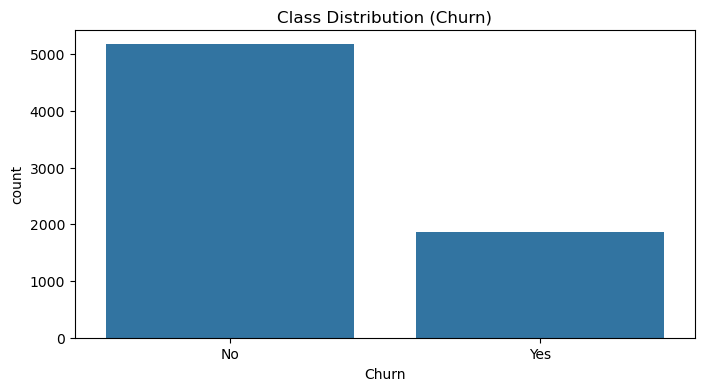

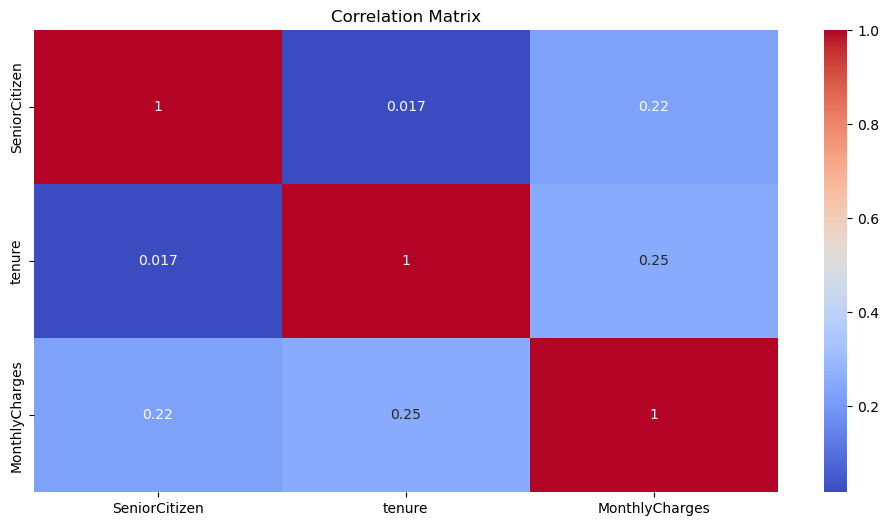

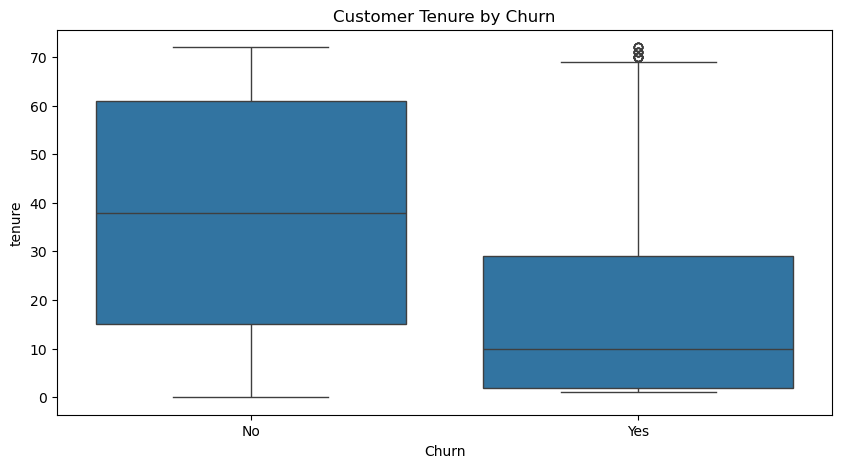

In [3]:
# Summary statistics
print(df.describe())

# Check missing values
print(df.isnull().sum())

# Distribution of target variable ('Churn')
plt.figure(figsize=(8, 4))
sns.countplot(x='Churn', data=df)
plt.title('Class Distribution (Churn)')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 6))
corr_matrix = df.select_dtypes(include=['number']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Example: Tenure vs Churn
plt.figure(figsize=(10, 5))
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Customer Tenure by Churn')
plt.show()

## Data Cleaning  

Steps Taken :   

1. Handling Missing Values : TotalCharges has 11 null values. These were dropped
1. Data Type Fixes : Converted categorical variables (e.g., "SeniorCitizen" from numeric to categorical).
1. Data Type Fixes : Convert TotalCharges to a numeric value
1. Feature Removal : Dropped redundant columns like "customerID" (no predictive value).
1. Feature Scaling : Used StandardScaler to standardize numerical features.
     

In [4]:
# Convert categorical variables to numerical (using one-hot encoding)
cat_df = pd.get_dummies(df, columns=['gender', 'Partner', 'Dependents', 'PhoneService', 
                                'MultipleLines', 'InternetService', 'OnlineSecurity', 
                                'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                                'StreamingTV', 'StreamingMovies', 'Contract', 
                                'PaperlessBilling', 'PaymentMethod'], drop_first=True)

cat_df['TotalCharges'] = pd.to_numeric(cat_df['TotalCharges'], errors='coerce')

print(f'# of null values for TotalCharges: {cat_df['TotalCharges'].isnull().sum()}')
cat_df.dropna(subset=['TotalCharges'], inplace=True)

cat_df = cat_df.drop('customerID', axis=1)

# Split features and target
X = cat_df.drop('Churn', axis=1)  # Target is 'Churn'
y = cat_df['Churn']

# Feature scaling (standardize numerical features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.select_dtypes(include=['float64', 'int64']))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, 
                                                    stratify=y, random_state=42)

# of null values for TotalCharges: 11


## Model Selection & Justification  

 - Models Used :
     - RandomForestClassifier  (base model).
     - Logistic Regression  (to handle collinearity explicitly via regularization).
 - Rationale :
     - RandomForest is robust to non-linear relationships and imbalanced data.
     - Logistic Regression was included to assess feature significance and handle collinearity via L1/L2 regularization.
         
     

Random Forest Accuracy: 0.7583511016346838

Classification Report:
               precision    recall  f1-score   support

          No       0.81      0.87      0.84      1033
         Yes       0.56      0.44      0.49       374

    accuracy                           0.76      1407
   macro avg       0.68      0.66      0.67      1407
weighted avg       0.74      0.76      0.75      1407



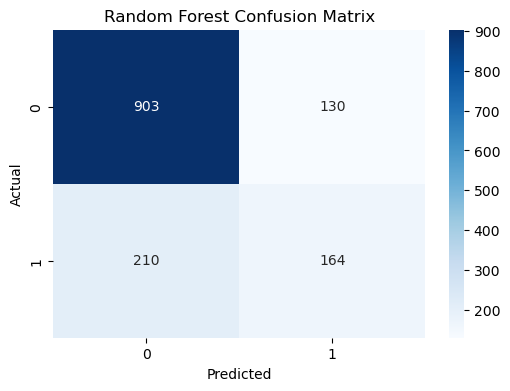


Logistic Regression Accuracy: 0.7789623312011372

Classification Report:
               precision    recall  f1-score   support

          No       0.82      0.90      0.86      1033
         Yes       0.62      0.45      0.52       374

    accuracy                           0.78      1407
   macro avg       0.72      0.67      0.69      1407
weighted avg       0.76      0.78      0.77      1407



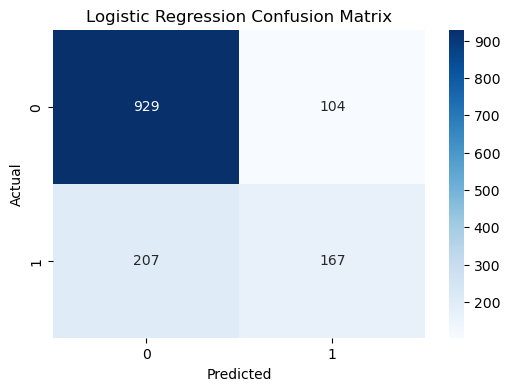


Adaboost Accuracy: 0.7810945273631841

Classification Report:
               precision    recall  f1-score   support

          No       0.81      0.91      0.86      1033
         Yes       0.63      0.43      0.51       374

    accuracy                           0.78      1407
   macro avg       0.72      0.67      0.68      1407
weighted avg       0.77      0.78      0.77      1407



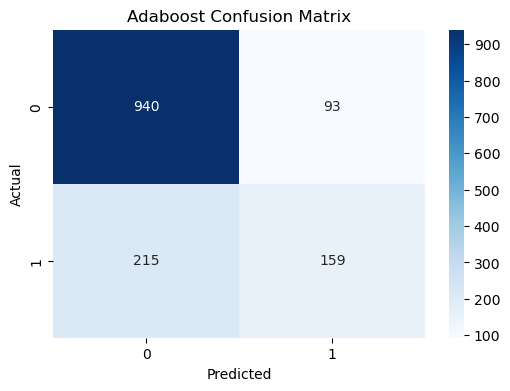

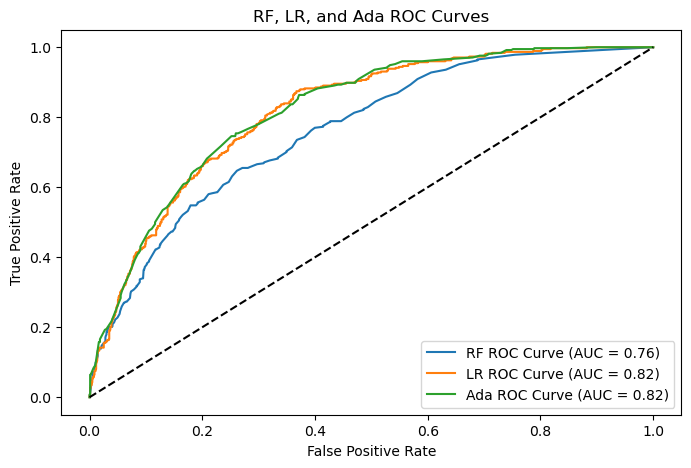

In [9]:
# Train a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, max_features=None, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Train a Logistic Regression model
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# Predictions for Logistic Regression
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

# Train an Adaboost Classifier
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train, y_train)

# Predictions for Adaboost
y_pred_ada = ada.predict(X_test)
y_prob_ada = ada.predict_proba(X_test)[:, 1]

# Metrics
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Metrics for Logistic Regression
print("\nLogistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# Metrics for Adaboost
print("\nAdaboost Accuracy:", accuracy_score(y_test, y_pred_ada))
print("\nClassification Report:\n", classification_report(y_test, y_pred_ada))

# Confusion Matrix for Adaboost
cm_ada = confusion_matrix(y_test, y_pred_ada)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_ada, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Adaboost Confusion Matrix')
plt.show()

# Encode labels
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)

# ROC Curve for Random Forest and Logistic Regression
fpr_rf, tpr_rf, _= roc_curve(y_test_encoded, y_prob_rf)
auc_rf = roc_auc_score(y_test_encoded, y_prob_rf)
plt.figure(figsize=(8, 5))
plt.plot(fpr_rf, tpr_rf, label=f'RF ROC Curve (AUC = {auc_rf:.2f})')
fpr_lr, tpr_lr, _= roc_curve(y_test_encoded, y_prob_lr)
auc_lr = roc_auc_score(y_test_encoded, y_prob_lr)
plt.plot(fpr_lr, tpr_lr, label=f'LR ROC Curve (AUC = {auc_lr:.2f})')

# Plot Adaboost ROC curve
fpr_ada, tpr_ada, _= roc_curve(y_test_encoded, y_prob_ada)
auc_ada = roc_auc_score(y_test_encoded, y_prob_ada)
plt.plot(fpr_ada, tpr_ada, label=f'Ada ROC Curve (AUC = {auc_ada:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF, LR, and Ada ROC Curves')
plt.legend()
plt.show() 

## Hyperparameter Tuning
Before hyperparameter tuning, LinearRegression, and AdaBoost performed nearly indentically, and RandomForest lagged just behind.

Now we will run gridsearchCV to tune the parameters.

In [6]:
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['log2', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5)
grid_search_rf.fit(X_train, y_train)

print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
print("Best Score for Random Forest:", grid_search_rf.best_score_)

rf_tuned = grid_search_rf.best_estimator_
y_pred_rf_tuned = rf_tuned.predict(X_test)

# Hyperparameter Tuning for Logistic Regression

param_grid_lr = {
    'C': [0.1, 1, 10],
    'max_iter': [1000, 5000]
}

grid_search_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=5)
grid_search_lr.fit(X_train, y_train)

print("Best Parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best Score for Logistic Regression:", grid_search_lr.best_score_)

lr_tuned = grid_search_lr.best_estimator_
y_pred_lr_tuned = lr_tuned.predict(X_test)

# Hyperparameter Tuning for Adaboost

param_grid_ada = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.1, 1, 10]
}

grid_search_ada = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid_ada, cv=5)
grid_search_ada.fit(X_train, y_train)

print("Best Parameters for Adaboost:", grid_search_ada.best_params_)
print("Best Score for Adaboost:", grid_search_ada.best_score_)

ada_tuned = grid_search_ada.best_estimator_
y_pred_ada_tuned = ada_tuned.predict(X_test)

Best Parameters for Random Forest: {'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best Score for Random Forest: 0.7893333333333332
Best Parameters for Logistic Regression: {'C': 0.1, 'max_iter': 1000}
Best Score for Logistic Regression: 0.7939555555555555
Best Parameters for Adaboost: {'learning_rate': 1, 'n_estimators': 100}
Best Score for Adaboost: 0.7937777777777777


Random Forest Accuracy: 0.7761194029850746

Classification Report:
               precision    recall  f1-score   support

          No       0.82      0.89      0.85      1033
         Yes       0.60      0.45      0.52       374

    accuracy                           0.78      1407
   macro avg       0.71      0.67      0.69      1407
weighted avg       0.76      0.78      0.77      1407



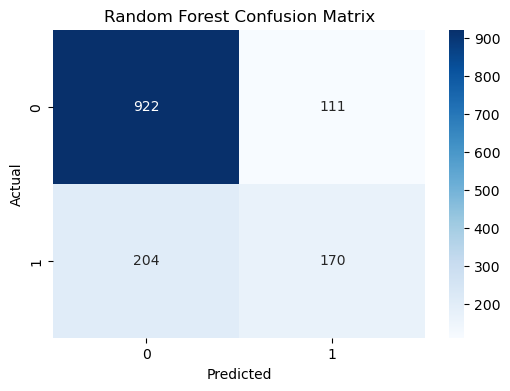


Logistic Regression Accuracy: 0.7782515991471215

Classification Report:
               precision    recall  f1-score   support

          No       0.82      0.90      0.86      1033
         Yes       0.62      0.44      0.51       374

    accuracy                           0.78      1407
   macro avg       0.72      0.67      0.69      1407
weighted avg       0.76      0.78      0.77      1407



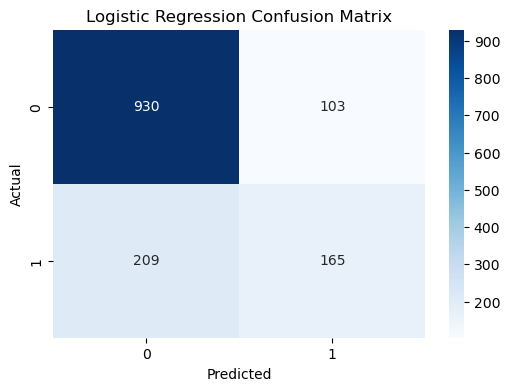


Adaboost Accuracy: 0.7810945273631841

Classification Report:
               precision    recall  f1-score   support

          No       0.81      0.91      0.86      1033
         Yes       0.63      0.43      0.51       374

    accuracy                           0.78      1407
   macro avg       0.72      0.67      0.68      1407
weighted avg       0.77      0.78      0.77      1407



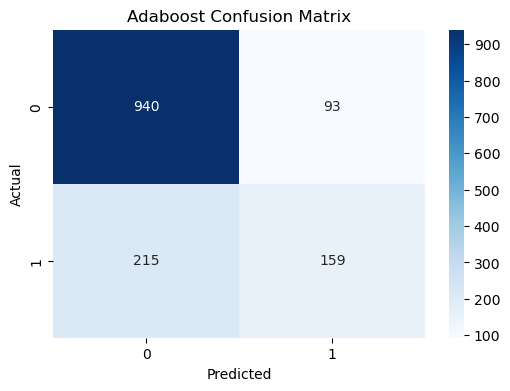

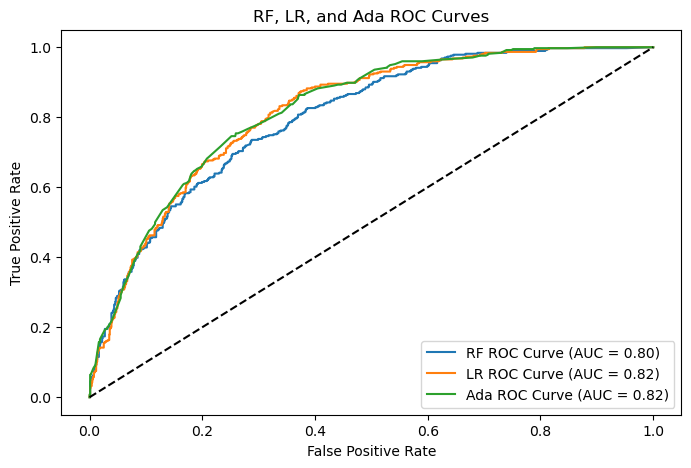

In [10]:
# Make predictions
y_pred_rf = rf_tuned.predict(X_test)
y_prob_rf = rf_tuned.predict_proba(X_test)[:, 1]
y_pred_lr = lr_tuned.predict(X_test)
y_prob_lr = lr_tuned.predict_proba(X_test)[:, 1]
y_pred_ada = ada_tuned.predict(X_test)
y_prob_ada = ada_tuned.predict_proba(X_test)[:, 1]

# Metrics
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

print("\nLogistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

print("\nAdaboost Accuracy:", accuracy_score(y_test, y_pred_ada))
print("\nClassification Report:\n", classification_report(y_test, y_pred_ada))

# Confusion Matrix for Adaboost
cm_ada = confusion_matrix(y_test, y_pred_ada)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_ada, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Adaboost Confusion Matrix')
plt.show()

# Encode labels
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)

# ROC Curve
fpr_rf, tpr_rf, _= roc_curve(y_test_encoded, y_prob_rf)
auc_rf = roc_auc_score(y_test_encoded, y_prob_rf)
plt.figure(figsize=(8, 5))
plt.plot(fpr_rf, tpr_rf, label=f'RF ROC Curve (AUC = {auc_rf:.2f})')
fpr_lr, tpr_lr, _= roc_curve(y_test_encoded, y_prob_lr)
auc_lr = roc_auc_score(y_test_encoded, y_prob_lr)
plt.plot(fpr_lr, tpr_lr, label=f'LR ROC Curve (AUC = {auc_lr:.2f})')

# Plot Adaboost ROC curve
fpr_ada, tpr_ada, _= roc_curve(y_test_encoded, y_prob_ada)
auc_ada = roc_auc_score(y_test_encoded, y_prob_ada)
plt.plot(fpr_ada, tpr_ada, label=f'Ada ROC Curve (AUC = {auc_ada:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF, LR, and Ada ROC Curves')
plt.legend()
plt.show()

## Conclusion
After hyperparameter tuning we can see that all 3 models perform very similarly. 

For the business case we chose (best identification all potential customer churn), RandomForest performed best. While it's accuracy and AUC were slightly lower, it has the lowest number of customers at risk of churning that were misclassified as not at risk.

However, the scores were close enough that cost benefit analysis should be performed to compare the cost of retention strategies against the cost of customer churn while using the models.